In [1]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2


2025-06-16 16:50:29.721741: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 16:50:29.733004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:50:29.733056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 1000

random_seed = 1

In [3]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=20,
                                M_max=200,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [4]:
# EXAMPLE 1
sde_gamma = .5
sde_beta = 10

def true_drift(x):
    x = np.atleast_2d(x)
    v = x[:,0]
    x = x[:,1]
    result = (-x**3 - x - sde_gamma * v)
    return result.reshape(-1, 1)

def true_diffusion(x):
    x = np.atleast_2d(x)
    result = np.dot(x, np.array([0, 0])) + np.sqrt(2 * sde_gamma / sde_beta)
    return result.reshape(-1, 1)

def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)

vlim = np.array([[-2.5, 2.5]])
xlim = np.array([[-2.5, 2.5]])

# NOTE: we are artificially using "symplectic" Euler here by considering "x_data" as "x(n+1)", not "x(n)"
# However, in "sample_data" x_data is sampled at random anyway, so no changes must be made inside the method.
# Note that in histogram trajectory generation, we generate using x(n+1) = x(n) + h*v(n).

step_sizes = np.zeros((n_pts, 1)) + step_size


In [5]:
# train networks
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed + i)

    # generate data
    x_data, y_data, p_data = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, vlim, plim=xlim)
    
    # build network
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)

    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, p_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=False)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]


drift epoch: 61
diff epoch: 50
Drift RMSE: 0.19290260061941653
Diffusion RMSE: 0.012318196354664987
Observed loss: -2.056602445840432
Observed validation loss: -2.0287421922361157
True loss: -2.035351991234516
Training time: 38.923155069351196


2025-06-16 16:51:21.699898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:51:21.700017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:51:21.700086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:51:21.

Theoretical mean min loss: -2.0349391062863957
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


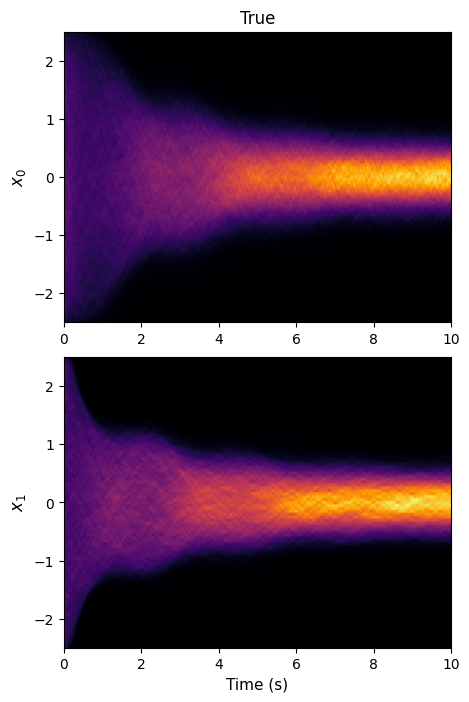

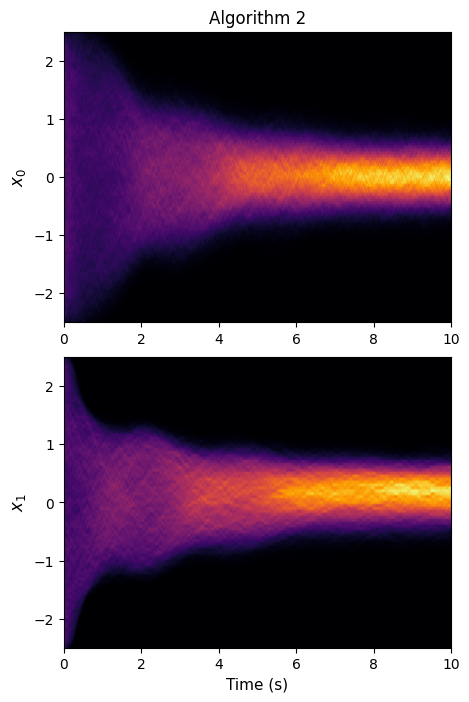

In [7]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

# calculate theoretical mean min loss (integral over loss function across input domain)
PR.mean_min_loss(true_diffusion, n_pts, validation_split, step_size, vlim, xlim=xlim, save=False)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

#PR.plot_parameter_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, p_data, save=False)

def coupled_func(x, p, step_size):
    return p + x*step_size

step_size_new = 0.1
time = 100*step_size_new
PR.plot_histogram(true_drift_diffusion, step_size, time, rng, vlim, plim=xlim, coupled_func=coupled_func, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, vlim, plim=xlim, coupled_func=coupled_func, name='Algorithm 2', save=True)
